# Requirement:
- numpy 1.19.5
- tensorflow 2.5.0
- tensorflow_privacy 0.6.1
- sklearn 0.24.2

Before performing the experiments, you need to fit the **pickle_file**(path for tabular QMNIST data) according to your own PC.

In [1]:
import numpy as np

import pickle
import tensorflow as tf
from tensorflow.keras import layers
import random as python_random

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances

# Load QMNIST data.

In [2]:
pickle_file = '/home/jiangnan/Desktop/ppml-workshop/data/QMNIST_tabular_ppml.pickle'

with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  x_defender = pickle_data['x_defender']
  x_reserve = pickle_data['x_reserve']
  y_defender = pickle_data['y_defender']
  y_reserve = pickle_data['y_reserve']
  del pickle_data
print('Data loaded.')

Data loaded.


In [3]:
NUM_CLASSES = 10

y_defender = y_defender[:,0]
y_reserve = y_reserve[:,0]

#y_defender = np.expand_dims(y_defender,axis=1)
#y_reserve = np.expand_dims(y_reserve,axis=1)

#y_defender = tf.keras.utils.to_categorical(y_defender, num_classes=NUM_CLASSES)
#y_reserve = tf.keras.utils.to_categorical(y_reserve, num_classes=NUM_CLASSES)

# Defender model $M_D$

import the defender model which need to be tested.

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

def defender_model_fn():
    """The architecture of the defender (victim) model.
    The attack is white-box, hence the attacker is assumed to know this architecture too."""
    
    random_seeds = random.sample(range(0,100), 2)
    np.random.seed(random_seeds[0])
    python_random.seed(random_seeds[1])
    
    model = SVC(probability=True,random_state=0)
    #model = MLPClassifier(random_state = 0,batch_size = 32)
    
    return model


# if random_select, randomly extract two points from both defender & reserve dataset, and repeat for n_extract times
random_select = True
n_extract = 100

#if given_index, the attack will put the two left out points back to their original place
given_index = False
n_sample = 6  #( 7 for 48 - 3200, 8 for 48 - 6400, etc.)


# Oracle attack model $M_A$

In [7]:
import random
from tqdm import tqdm

In [8]:
def create_mock_defender_models(defender, data_in, data_out, n_records = 48, random_select = True, n_extract = 100, given_index = False):
    
    difference_in = []
    difference_out = []
    
    number_loop = 0
    
    if random_select == True:
        number_loop = n_extract
    else:
        number_loop = data_in[0].shape[0]
        
    for i in tqdm(range(number_loop)):

        if random_select == True:
            index = random.randint(0,n_records-1)
        else:
            index = i

        evaluation_data_in = data_in[0][index]
        evaluation_label_in = data_in[1][index]

        evaluation_data_out = data_out[0][index]
        evaluation_label_out = data_out[1][index]

        evaluation_data = np.array([evaluation_data_in, evaluation_data_out])
        evaluation_label = np.array([evaluation_label_in, evaluation_label_out])

        evaluation = evaluation_data, evaluation_label


        attack_train_data_in = np.delete(data_in[0], index, axis=0)
        attack_train_label_in = np.delete(data_in[1], index, axis=0)

        attack_in = attack_train_data_in, attack_train_label_in


        attack_train_data_out = np.delete(data_out[0], index, axis=0)
        attack_train_label_out = np.delete(data_out[1], index, axis=0)

        attack_out = attack_train_data_out, attack_train_label_out

        #predict = defender_model.predict(attack_in[0])
        predict = defender_model.predict_proba(attack_in[0])
        #predict = defender_model.predict_log_proba(attack_in[0])

        
        if given_index == True:

            attack_in_plus_one_in = np.insert(attack_in[0], index, evaluation[0][0].reshape(1,attack_in[0].shape[1]), axis=0), np.insert(attack_in[1], index, evaluation[1][0], axis=0)
            attack_in_plus_one_out = np.insert(attack_in[0], index, evaluation[0][1].reshape(1,attack_in[0].shape[1]), axis=0), np.insert(attack_in[1], index, evaluation[1][1], axis=0)

        else:

            attack_in_plus_one_in = np.vstack((evaluation[0][0].reshape(1,attack_in[0].shape[1]),attack_in[0])), np.hstack(( evaluation[1][0],attack_in[1]))
            attack_in_plus_one_out = np.vstack((evaluation[0][1].reshape(1,attack_in[0].shape[1]),attack_in[0])), np.hstack(( evaluation[1][1],attack_in[1]))

        
        M_cD_in = defender_model_fn()
        M_cD_out = defender_model_fn()

        M_cD_in.fit(attack_in_plus_one_in[0], attack_in_plus_one_in[1])
        M_cD_out.fit(attack_in_plus_one_out[0], attack_in_plus_one_out[1])
        
        #M_cD_in_predict = M_cD_in.predict(attack_in[0])
        #M_cD_out_predict = M_cD_out.predict(attack_in[0])
        
        M_cD_in_predict = M_cD_in.predict_proba(attack_in[0])
        M_cD_out_predict = M_cD_out.predict_proba(attack_in[0])

        #M_cD_in_predict = M_cD_in.predict_log_proba(attack_in[0])
        #M_cD_out_predict = M_cD_out.predict_log_proba(attack_in[0])

        diff_in = np.mean(np.linalg.norm(M_cD_in_predict-predict))
        diff_out = np.mean(np.linalg.norm(M_cD_out_predict-predict))

        difference_in.append(diff_in)
        difference_out.append(diff_out)
    
    return difference_in, difference_out


# Start experiments:

In [9]:
accuracy_in_all = []
accuracy_out_all = []

difference_in_all = []
difference_out_all = []

number_records = [48, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 200000]

#diff_in_out = x_reserve.shape[0] - x_defender.shape[0]

for n_records in number_records[:n_sample]:
    
    random_indexes = random.sample(range(0,200000), n_records)
    data_in = x_defender[random_indexes], y_defender[random_indexes]
    data_out = x_reserve[random_indexes], y_reserve[random_indexes]
    defender_model = defender_model_fn()
    defender_model.fit(data_in[0],data_in[1])
    
    predict_in_proba = defender_model.predict(data_in[0])
    #predict_in = np.argmax(predict_in_proba, axis=1)
    acc_in = accuracy_score(data_in[1], predict_in_proba)
    
    predict_out_proba = defender_model.predict(data_out[0])
    #predict_out = np.argmax(predict_out_proba, axis=1)
    acc_out = accuracy_score(data_out[1], predict_out_proba)
    
    '''
    auc_by_class = []
    # compute auc per class then take the average value
    for i in range(NUM_CLASSES):
      class_indices = data_out[1] == i
      if np.sum(class_indices) == 0:
        continue
      fpr, tpr, thresholds = metrics.roc_curve(class_indices, predict_reserve_proba[:,i])
      auc = metrics.auc(fpr, tpr)
      auc_by_class.append(auc)
    
    average_auc = np.mean(auc_by_class)
    utility = max(2*average_auc -1,0)
    
    defender_acc_all.append(acc)
    defender_auc_all.append(average_auc)
    '''
    accuracy_in_all.append(acc_in)
    accuracy_out_all.append(acc_out)
    
    difference_in, difference_out = create_mock_defender_models(defender = defender_model,
                                                                    data_in = data_in,
                                                                    data_out = data_out,
                                                                    n_records = n_records,
                                                                    random_select = random_select,
                                                                    n_extract = n_extract,
                                                                    given_index = given_index)
    
    difference_in_all.append(difference_in)
    difference_out_all.append(difference_out)

100%|██████████| 100/100 [07:44<00:00,  4.64s/it]


In [10]:
print(accuracy_in_all)
print(accuracy_out_all)

[0.6666666666666666, 0.86, 0.865, 0.9225, 0.94, 0.93625]
[0.4791666666666667, 0.76, 0.75, 0.8525, 0.89875, 0.905]


In [114]:
print(accuracy_in_all)
print(accuracy_out_all)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.5208333333333334, 0.72, 0.765, 0.8375, 0.88875, 0.920625]


In [11]:
# compute the privacy values by comparing all model pairs

privacy_all = []
variance_all = []
sigma_error_all = []

for i in range(len(difference_in_all)):
    
    difference_in = difference_in_all[i]
    difference_out = difference_out_all[i]
    
    results = []

    for j in tqdm(range(len(difference_in))):
        for k in range(len(difference_out)):
            
            if difference_in[j] == difference_out[k]:
                random_number = random.randint(0,99)
                if random_number < 50:
                    results.append(1)
                else:
                    results.append(0)

            elif difference_in[j] < difference_out[k]:
                results.append(1)
            else:
                results.append(0)

    n = len(results)
    p = 1-np.sum(results)/n

    privacy = min(2*p,1)
    variance = 2*p*(1-p)/n
    sigma_error = 2*np.sqrt(p*(1-p)/n)
    
    privacy_all.append(privacy)
    variance_all.append(variance)
    sigma_error_all.append(sigma_error)
    

100%|██████████| 100/100 [00:00<00:00, 13393.91it/s]


In [12]:
privacy_all

[0.0,
 0.14579999999999993,
 0.21599999999999997,
 0.03279999999999994,
 0.11339999999999995,
 0.09499999999999997]

In [13]:
variance_all

[0.0,
 1.3517117999999994e-05,
 1.9267199999999997e-05,
 3.2262079999999944e-06,
 1.0697021999999994e-05,
 9.048749999999997e-06]

In [14]:
sigma_error_all

[0.0,
 0.005199445739691875,
 0.00620760823506123,
 0.0025401606248424504,
 0.0046253696068530555,
 0.004254115654281156]

In [15]:
np.mean(privacy_all)

0.10049999999999996

In [36]:
utility_all

[0.8130471608873677,
 0.8921901043665099,
 0.9414532813976184,
 0.9677724063210493,
 0.982617745125155,
 0.9908631663203142]

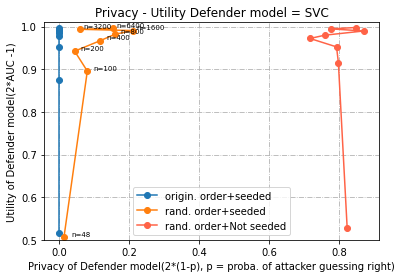

In [29]:
# plot the privacy - utility curve

import matplotlib.pyplot as plt

plt.figure()
plt.grid(linestyle='-.',)

plt.plot(privacy_all_1,utility_all_1,marker='o',label = 'origin. order+seeded')
plt.plot(privacy_all,utility_all,marker='o', label = 'rand. order+seeded')
plt.plot(privacy_all_2,utility_all_2,marker='o',color='tomato',label = 'rand. order+Not seeded')
plt.title("Privacy - Utility Defender model = SVC")
plt.xlabel('Privacy of Defender model(2*(1-p), p = proba. of attacker guessing right)')
plt.ylabel('Utility of Defender model(2*AUC -1)')
number_records = [48, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 200000]
i=0
for a,b in zip(privacy_all,utility_all):
    
    plt.text(a+0.05, b, 'n={}'.format(number_records[i]), ha='center', va= 'bottom',fontsize=7)
    i+=1

#plt.xlim((0,1))
plt.ylim((0.5,1.01))
plt.legend()
plt.show()